# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [6]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00040863  0.00643517 -0.00183948 -0.00446832 -0.00652582  0.02232316
   0.01718616  0.00127051 -0.00061686  0.00939713 -0.02515256 -0.01520577
  -0.02182542  0.00631259 -0.00286694]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [7]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: 0.5336658354114713


## Deep Reinforcement Learning

### SARSA

#### Training

In [1]:
import d_sarsa

model, report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 0.419  train_loss: 0.113  train_acc: 0.500  (2.70s - 1283.61s remaining)    Avg. Loss: 0.16212076024094985
EPOCH: 1.003  train_loss: 0.048  train_acc: 0.500  (5.21s - 1034.13s remaining)    Avg. Loss: 0.13180754409660517
EPOCH: 2.528  train_loss: 0.099  train_acc: 0.400  (7.79s - 608.70s remaining)    Avg. Loss: 0.12607812204144217
EPOCH: 3.264  train_loss: 0.132  train_acc: 0.333  (10.35s - 623.76s remaining)    Avg. Loss: 0.12616336203652742
EPOCH: 4.628  train_loss: 0.237  train_acc: 0.500  (12.88s - 543.86s remaining)    Avg. Loss: 0.12310226124511961
EPOCH: 5.496  train_loss: 0.215  train_acc: 0.500  (15.47s - 547.52s remaining)    Avg. Loss: 0.12157335539301994
EPOCH: 6.261  train_loss: 0.036  train_acc: 0.500  (18.02s - 557.63s remaining)    Avg. Loss: 0.09757798801168056
EPOCH: 7.076  train_loss: 0.019  train_acc: 0.577  (20.55s - 560.25s remaining)    Avg. Loss: 0.09457754212652833
EPOCH: 8.686  train_loss: 0.176  train_acc: 0.500  (23.15s - 509.93s remaining)    Avg. L

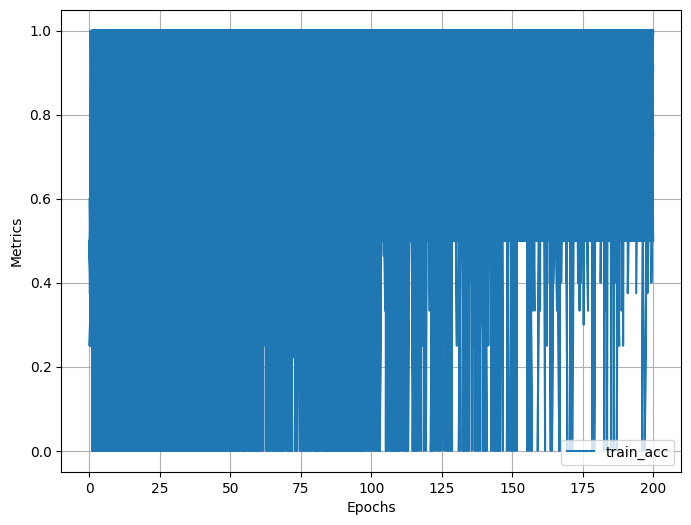

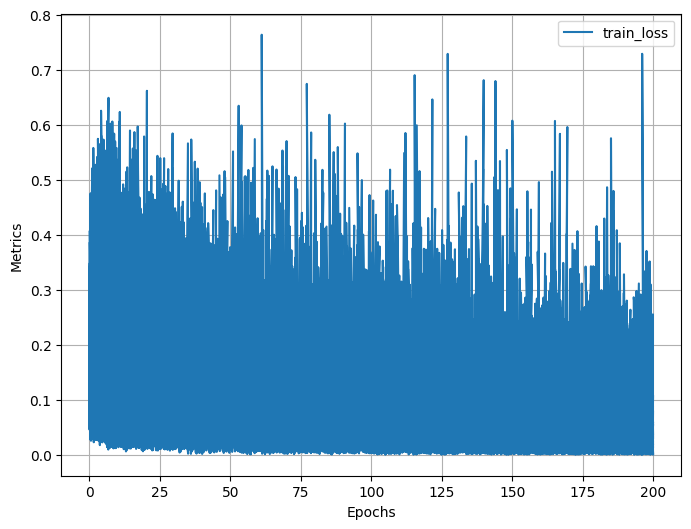

In [10]:
report.plot('train_acc')
report.plot('train_loss')

#### Evaluation

In [4]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

score = eval.score_model(test_dataset, nn_predict)

print(f"NN Sarsa Accuracy: {score}")

NN Sarsa Accuracy: 0.5635910224438903


### MC

#### Training

In [8]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 0.595  train_loss: 0.235  train_acc: 0.500  (3.13s - 1047.41s remaining)    Avg. Loss: 0.2522866316030452
EPOCH: 1.290  train_loss: 0.249  train_acc: 0.500  (6.03s - 928.78s remaining)    Avg. Loss: 0.24354688766415167
EPOCH: 3.000  train_loss: 0.140  train_acc: 1.000  (8.98s - 589.69s remaining)    Avg. Loss: 0.2375715747257132
EPOCH: 3.718  train_loss: 0.241  train_acc: 0.500  (11.89s - 627.54s remaining)    Avg. Loss: 0.23420780655706733
EPOCH: 4.883  train_loss: 0.221  train_acc: 0.700  (14.77s - 590.31s remaining)    Avg. Loss: 0.23142667042632256
EPOCH: 5.842  train_loss: 0.251  train_acc: 0.500  (17.76s - 590.13s remaining)    Avg. Loss: 0.2291236662925863
EPOCH: 6.073  train_loss: 0.357  train_acc: 0.286  (20.84s - 665.59s remaining)    Avg. Loss: 0.2264336569130945
EPOCH: 7.062  train_loss: 0.233  train_acc: 0.500  (23.75s - 649.01s remaining)    Avg. Loss: 0.223118624543427
EPOCH: 8.771  train_loss: 0.281  train_acc: 0.364  (26.67s - 581.50s remaining)    Avg. Loss: 0.

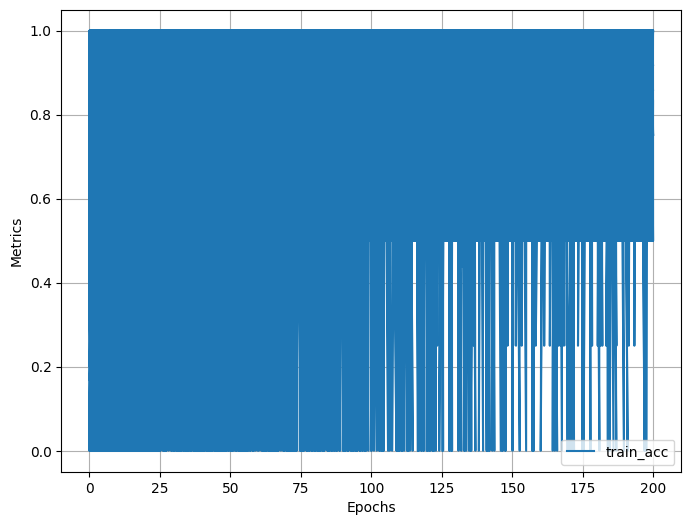

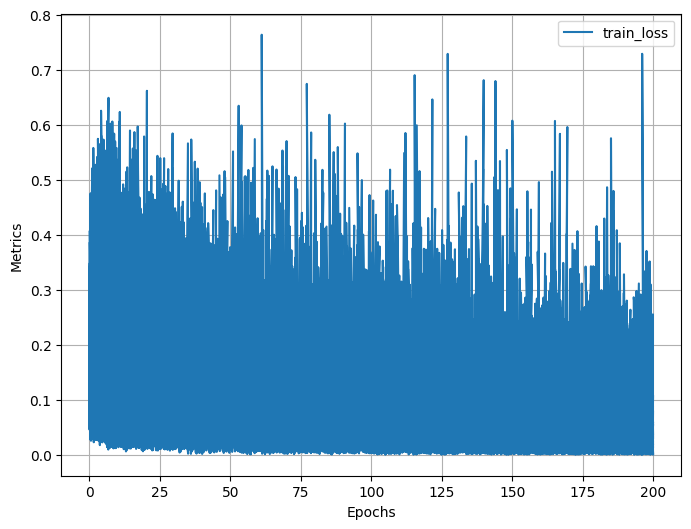

In [11]:
nn_mc_report.plot('train_acc')
report.plot('train_loss')

#### Evaluation

In [12]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

score = eval.score_model(test_dataset, nn_mc_predict)

print(f"NN Sarsa Accuracy: {score}")

NN Sarsa Accuracy: 0.5673316708229427


## Conclusion

### Summary

### Future extensions